In [2]:
import os, sys, re, pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf
import time
from tensorflow import keras
print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)
    
from Data import Prepro_data

sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
tensorflow 2.1.0
matplotlib 3.2.0
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [7]:
origin_DATA = Prepro_data.DataLoad()
origin_DATA.features.head()

,User-ID,Location,ISBN,Title,Author,Year,Publisher,Blurb
0,2918,"[1242, 7251, 5372]",32719,"[18416, 3305, 2794, 2794, 2794, 2794, 2794, 27...",13704,63,2346,"[16743, 70936, 91023, 94647, 30725, 94201, 110..."
1,2918,"[1242, 7251, 5372]",23709,"[5042, 20096, 12301, 3565, 6702, 20408, 4956, ...",6881,71,2064,"[26888, 9440, 6976, 72713, 117446, 20931, 2329..."
2,24974,"[4759, 1444, 5372]",23709,"[5042, 20096, 12301, 3565, 6702, 20408, 4956, ...",6881,71,2064,"[26888, 9440, 6976, 72713, 117446, 20931, 2329..."
3,18233,"[7245, 30, 1600]",23709,"[5042, 20096, 12301, 3565, 6702, 20408, 4956, ...",6881,71,2064,"[26888, 9440, 6976, 72713, 117446, 20931, 2329..."
4,240,"[4723, 6498, 1600]",23709,"[5042, 20096, 12301, 3565, 6702, 20408, 4956, ...",6881,71,2064,"[26888, 9440, 6976, 72713, 117446, 20931, 2329..."


In [8]:
#User-ID number,max_index
all_user_id_number = len(set(origin_DATA.features['User-ID']))
print('all_user_id_number=',all_user_id_number)

#Location number index
location_length = len(origin_DATA.features['Location'][0])
all_location_words_number = max([j for i in origin_DATA.features['Location'] for j in i])+1
print('location_length=%d,all_location_words_number=%d '% (location_length,all_location_words_number) )

#ISBN numner
all_isbn_words_number = len(set(origin_DATA.features['ISBN']))
print('all_isbn_words_number ',all_isbn_words_number)

#Title
title_length = len(origin_DATA.features['Title'][0])
all_title_words_number = max([j for i in origin_DATA.features['Title'] for j in i])+1
print('title_length=%d,all_title_words_number=%d'% (title_length,all_title_words_number))

#Author
all_author_words_number = len(set(origin_DATA.features['Author']))
print('all_author_words_number ',all_author_words_number)

#Year
all_year_words_number = len(set(origin_DATA.features['Year']))
print('all_year_words_number ',all_year_words_number)

# Publisher
all_publisher_words_number = len(set(origin_DATA.features['Publisher']))
print('all_publisher_words_number ',all_publisher_words_number)

# Blurb
blurb_length = len(origin_DATA.features['Blurb'][0])
all_blurb_words_number = max([j for i in origin_DATA.features['Blurb'] for j in i])+1
print('blurb_length=%d,all_blurb_words_number=%d'% (blurb_length,all_blurb_words_number))

all_user_id_number= 28836
location_length=3,all_location_words_number=7574 
all_isbn_words_number  38036
title_length=15,all_title_words_number=23731
all_author_words_number  15196
all_year_words_number  81
all_publisher_words_number  2909
blurb_length=200,all_blurb_words_number=127035


In [9]:
"""
超参数
"""
# Number of Epochs
num_epochs = 5
# Batch_size
batch_size = 256
# dropout_keep
dropout_keep = 0.5
# Learning_rate
learning_rate = 0.001
# embedding_dim
embedding_dim = 16
# 文本卷积滑动的单词个数
window_sizes = {2,3,4,5}
# filter num
filter_num = 8
# dense dim
dense_dim = 32

In [10]:
def get_inputs():
#     用户特征输入占位符
    # 用户特征输入
    user_id = keras.layers.Input(shape=(1,), dtype='int32', name='user_id_input')
    user_location = keras.layers.Input(shape=(3,), dtype='int32', name='user_location_input')
    
    # 书籍特征输入
    book_isbn = keras.layers.Input(shape=(1,),  dtype='int32', name='book_isbn_input')
    book_author = keras.layers.Input(shape=(1,),  dtype='int32', name='book_author_input')
    book_year = keras.layers.Input(shape=(1,),  dtype='int32', name='book_year_input')
    book_publisher = keras.layers.Input(shape=(1,),  dtype='int32', name='book_publisher_input')  
    book_title = keras.layers.Input(shape=(15, ), dtype='int32', name='book_title_input')
    book_blurb = keras.layers.Input(shape=(200, ), dtype='int32', name='book_blurb_input')
    return user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb

In [11]:
"""
构建User神经网络
"""
def get_user_embedding(user_id,user_location):
    uid_embed_layer = tf.keras.layers.Embedding(all_user_id_number,embedding_dim,input_length=1,name='uid_embed_layer')(user_id)
    location_embed_layer = tf.keras.layers.Embedding(all_location_words_number,embedding_dim,input_length=location_length,name='location_embed_layer')(user_location)
    return uid_embed_layer, location_embed_layer

In [12]:
def get_user_feature_layer(uid_embed_layer,location_embed_layer):
#     第一层全连接
    uid_fc_layer = tf.keras.layers.Dense(dense_dim,name='uid_fc_layer',activation='relu')(uid_embed_layer)
    location_fc_layer = tf.keras.layers.Dense(dense_dim,name='location_fc_layer',activation='relu')(location_embed_layer)
#  对location进行Encoder提取特征
    location_gru_layer = tf.keras.layers.GRU(units=dense_dim,dropout=0.5,name='location_gru_layer')(location_fc_layer)
#     [None,32]
    print(location_gru_layer.shape)
    location_gru_expand_layer = tf.expand_dims(location_gru_layer,axis=1)
    
#     第二层全连接
    user_combine_layer = tf.keras.layers.concatenate([uid_fc_layer,location_gru_expand_layer],2)
    user_dense_layer = tf.keras.layers.Dense(200,activation='tanh',name='user_dense_layer')(user_combine_layer)
    user_dense_layer_flat = tf.keras.layers.Reshape([200], name="user_combine_layer_flat")(user_dense_layer)
    return user_dense_layer,user_dense_layer_flat

In [13]:
"""
构建book神经网络
"""
def get_book_embedding(book_isbn, book_author, book_year, book_publisher, book_title, book_blurb):
    book_isbn_embed_layer = tf.keras.layers.Embedding(all_isbn_words_number,embedding_dim,input_length = 1,name='book_isbn_embed_layer')(book_isbn)
    book_author_embed_layer = tf.keras.layers.Embedding(all_author_words_number,embedding_dim,input_length=1,name='book_author_embed_layer')(book_author)
    book_year_embed_layer = tf.keras.layers.Embedding(all_year_words_number,embedding_dim,input_length=1,name='book_year_embed_layer')(book_year)
    book_publisher_embed_layer = tf.keras.layers.Embedding(all_publisher_words_number,embedding_dim,input_length = 1,name='book_publisher_embed_layer')(book_publisher)
    book_title_embed_layer = tf.keras.layers.Embedding(all_title_words_number,embedding_dim,input_length=title_length,name='book_title_embed_layer')(book_title)
    book_blurb_embed_layer = tf.keras.layers.Embedding(all_blurb_words_number,embedding_dim,input_length = blurb_length,name='book_blurb_embed_layer')(book_blurb)
    return book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer
    

In [14]:
def get_book_feature_layer(book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer):
#     对isbn,author,year,publisher第一层全连接
    book_isbn_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_isbn_dense_layer')(book_isbn_embed_layer)
    book_author_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_author_dense_layer')(book_author_embed_layer)
    book_year_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_year_dense_layer')(book_year_embed_layer)
    book_publisher_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_publisher_dense_layer')(book_publisher_embed_layer)
    book_title_embed_layer_expand = tf.expand_dims(book_title_embed_layer,axis=-1)
#     对title进行文本卷积
#     book_title_embed_layer_expand:[None,15,16,1]
#     对文本嵌入层使用不同的卷积核做卷积核最大池化
    pool_layer_list = []
    for window_size in window_sizes:
        title_conv_layer = tf.keras.layers.Conv2D(filters = filter_num,kernel_size = (window_size,embedding_dim),strides=1,activation='relu')(book_title_embed_layer_expand)
        title_maxpool_layer = tf.keras.layers.MaxPooling2D(pool_size=(title_length-window_size+1,1),strides=1)(title_conv_layer)
        pool_layer_list.append(title_maxpool_layer)
    pool_layer_layer = tf.keras.layers.concatenate(pool_layer_list,axis=-1,name='title_pool_layer')
    max_num = len(window_sizes)*filter_num
    pool_layer_flat = tf.keras.layers.Reshape([1,max_num],name='pool_layer_flat')(pool_layer_layer)
    dropout_layer = tf.keras.layers.Dropout(dropout_keep, name = "dropout_layer")(pool_layer_flat)

    # 对简介进行Encoder特征提取
    book_blurb_dense_layer = tf.keras.layers.Dense(dense_dim,activation='relu',name='book_blurb_dense_layer')(book_blurb_embed_layer)
    book_blurb_gru_layer = tf.keras.layers.GRU(units=dense_dim,dropout=0.5,name='book_blurb_gru_layer')(book_blurb_dense_layer)
    print('book_blurb_gru_layer=',book_blurb_gru_layer.shape)
    book_blurb_gru_expand_layer = tf.expand_dims(book_blurb_gru_layer,axis=1)
    book_combine_layer = tf.keras.layers.concatenate([book_isbn_dense_layer,book_author_dense_layer,book_year_dense_layer,book_publisher_dense_layer,dropout_layer,book_blurb_gru_expand_layer],axis=-1)
    book_dense_layer = tf.keras.layers.Dense(200, activation='tanh')(book_combine_layer)
    book_dense_layer_flat = tf.keras.layers.Reshape([200], name="book_dense_layer_flat")(book_dense_layer)
    return book_dense_layer,book_dense_layer_flat

In [15]:
def get_rating(user_feature, book_feature):
    multiply_layer = keras.layers.Lambda(lambda layer: tf.reduce_sum(layer[0]*layer[1],axis=1,keepdims=True), name = 'user_book_feature')((user_feature, book_feature))
    print(multiply_layer.shape)
    return multiply_layer

In [16]:
a = tf.constant([[2,1,1],[1,3,4]])
b = tf.constant([[0,1,1],[1,0,4]])
c = inference = tf.keras.layers.Lambda(lambda layer:tf.reduce_sum(a * b, axis=1,keepdims=True))(a,b)
c.shape

TensorShape([2, 1])

In [17]:
features = data.features.values

In [19]:
features[0]

array([2918, list([1242, 7251, 5372]), 32719,
       list([18416, 3305, 2794, 2794, 2794, 2794, 2794, 2794, 2794, 2794, 2794, 2794, 2794, 2794, 2794]),
       13704, 63, 2346,
       list([16743, 70936, 91023, 94647, 30725, 94201, 110675, 90181, 124050, 43353, 17884, 63098, 25481, 55269, 5885, 41278, 4336, 123778, 68058, 98997, 76124, 102306, 1763, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3630, 3

In [20]:
targets=data.labels.values
type(targets)

numpy.ndarray

In [21]:
# get_Batch
def get_batch(Xs,ys,batchsize):
    for start in range(0,len(Xx,batchsize)):
        end = min(start+batchsize,len(Xs))
        yield xS[start:end],ys[start:end]

# 构建计算图
将用户特征和书籍特征作为输入，经过一个全连接，输出预测

In [22]:
# test
a = np.array([[1, 2, 4, ([1, 2, 5])], 
             [3, 2, 6, ([6, 5, 1])],
             [6, 9, 4, ([3, 7, 5])]])
b = np.zeros([3,3])
for i in range(3):
    b[i] = a.take(3,1)[i]
b[:2]    

array([[1., 2., 5.],
       [6., 5., 1.]])

In [23]:
import math
dataset_length = len(features)

def get_train_val_test():
    location = np.zeros([dataset_length, 3])
    title = np.zeros([dataset_length, 15])
    blurb = np.zeros([dataset_length, 200])
    for i in range(dataset_length):
        location[i] = np.array(features[i, 1])
        title[i] = np.array(features[i, 3])
        blurb[i] = np.array(features[i, 7])
    input_features = [features.take(0, 1).astype(np.float64),
                      location,
                      features.take(2, 1).astype(np.float64),
                      title,
                      features.take(4, 1).astype(np.float64),
                      features.take(5, 1).astype(np.float64),
                      features.take(6, 1).astype(np.float64),
                      blurb]
    for i in range(len(input_features)):
        print(input_features[i].dtype)
        print(type(input_features[i]))
    labels = targets
    #     分割数据集以及shuffle
    np.random.seed(100)
    number_features = len(input_features)
    shuffle_index = np.random.permutation(dataset_length)
    shuffle_train_index = shuffle_index[:math.ceil(dataset_length * 0.96)]
    shuffle_val_index = shuffle_index[math.ceil(dataset_length * 0.96):math.ceil(dataset_length * 0.98)]
    shuffle_test_index = shuffle_index[math.ceil(dataset_length * 0.98):]
    train_features = [input_features[i][shuffle_train_index] for i in range(number_features)]
    train_labels = labels[shuffle_train_index]
    val_features = [input_features[i][shuffle_val_index] for i in range(number_features)]
    val_lables = labels[shuffle_val_index]
    test_features = [input_features[i][shuffle_test_index] for i in range(number_features)]
    test_lables = labels[shuffle_test_index]
    return train_features, train_labels, val_features, val_lables, test_features, test_lables

In [24]:
train_features, train_labels, val_features, val_lables, test_features, test_lables = get_train_val_test()
print(type(train_features))
print(type(train_labels))
print(val_features[0].shape)
print(test_features[0].shape)

float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
float64
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
(3442,)
(3442,)


In [25]:
class mv_network(object):
    def __init__(self, batch_size,epoch):
        self.batchsize = 256
        self.epoch = 5
         # 获取输入占位符
        user_id, user_location, book_isbn, book_author, book_year, book_publisher, book_title, book_blurb = get_inputs()
        # 获取User的2个嵌入向量
        uid_embed_layer, location_embed_layer = get_user_embedding(user_id,user_location)
        # 得到用户特征
        user_dense_layer,user_dense_layer_flat =get_user_feature_layer(uid_embed_layer,location_embed_layer)
        # 获取书籍的嵌入向量
        book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer=get_book_embedding(book_isbn, book_author, book_year, book_publisher, book_title, book_blurb)
        # 获取书籍特征
        book_dense_layer,book_dense_layer_flat=get_book_feature_layer(book_isbn_embed_layer,book_author_embed_layer,book_year_embed_layer,book_publisher_embed_layer,book_title_embed_layer,book_blurb_embed_layer)
        
        # 计算出评分
        # 将用户特征和电影特征做矩阵乘法得到一个预测评分的方案
        print("user_dense_layer_flat=",user_dense_layer_flat.shape)
        print("book_dense_layer_flat=",book_dense_layer_flat.shape)
        inference = get_rating(user_dense_layer_flat,book_dense_layer_flat)

        self.model = tf.keras.Model(
            inputs=[user_id, user_location, book_isbn, book_title, book_author, book_year, book_publisher, book_blurb],
            outputs=[inference])
        self.model.summary()
    def train_model(self):
        model_optimizer = tf.keras.optimizers.Adam()
        self.model.compile(optimizer=model_optimizer, loss=keras.losses.mse)
        history = self.model.fit(train_features, train_labels, validation_data=(val_features, val_lables), epochs=self.epoch, batch_size=self.batchsize, verbose=1)
        return  history
    def predict_model(self, model):
        test_loss = self.model.evaluate(test_features, test_lables, verbose=0)
        return test_loss

(None, 32)
book_blurb_gru_layer= (None, 32)
user_dense_layer_flat= (None, 200)
book_dense_layer_flat= (None, 200)
(None, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book_title_input (InputLayer)   [(None, 15)]         0                                            
__________________________________________________________________________________________________
book_title_embed_layer (Embeddi (None, 15, 16)       379696      book_title_input[0][0]           
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 15, 16, 1)]  0           book_title_embed_layer[0][0]     
__________________________________________________________________________________________________
user_location_input (InputLayer [(None, 3)]          0               

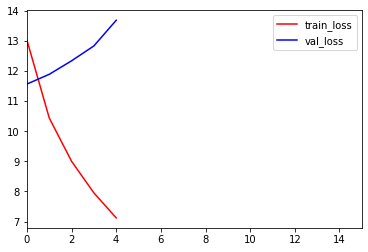

In [26]:
model = mv_network(256,5)
history = model.train_model()
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(1)
plt.plot(train_loss, c='r', label='train_loss')
plt.plot(val_loss, c='b', label='val_loss')
plt.legend()
plt.xlim([0, 15])
plt.show()

In [27]:
keras.utils.plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
